# EXPLORATION
# 4. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기[프로젝트]

## 캐글 private score: 112809.62315




## 4-1. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

In [1]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/aiffel/aiffel_project/data/kaggle_kakr_housing

Mounted at /content/drive
/content/drive/MyDrive/aiffel/aiffel_project/data/kaggle_kakr_housing


In [2]:
# %pip install xgboost==1.4.2
# %pip install lightgbm==3.3.0
# %pip install missingno==0.5.0

### 라이브러리 버전을 확인해 봅시다

In [3]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.7.5
3.3.5
0.5.2
1.2.2


## 여러 가지 실험을 해보고 결과 csv는 캐글에, 사용한 노트북은 깃허브(GitHub)를 통해 이곳에 제출해 주세요. 제출한 노트북에는 본인의 캐글 Submission 스코어를 기재해 주시기 바랍니다.

## 1. 데이터 준비

In [4]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


학습 데이터에서 price컬럼을 따로 y에 저장하고 삭제합니다

In [7]:
y = train['price']

del train['price']

In [8]:
print(f'train data dim : {train.shape}')
print(f'test data dim : {test.shape}')

train data dim : (15035, 20)
test data dim : (6468, 20)


train 데이터와 test 데이터의 컬럼 크기가 같아졌음을 확인할 수 있습니다

데이터 전처리를 위해 train과 test 데이터를 잠시 병합합니다

In [9]:
train_len = len(train)
train = pd.concat((train, test), axis=0)

print(len(train))

21503


노드 학습을 수행하며 결측치는 확인했기에 넘어갑니다

id컬럼을 제거합니다

In [10]:
del train['id']

train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


date컬럼의 데이터를 int 형식으로 변경합니다.

In [11]:
train['date'] = train['date'].apply(lambda i: i[:4]).astype(int)

train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2015,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2015,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,2014,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,2015,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


각 변수들의 분포 확인

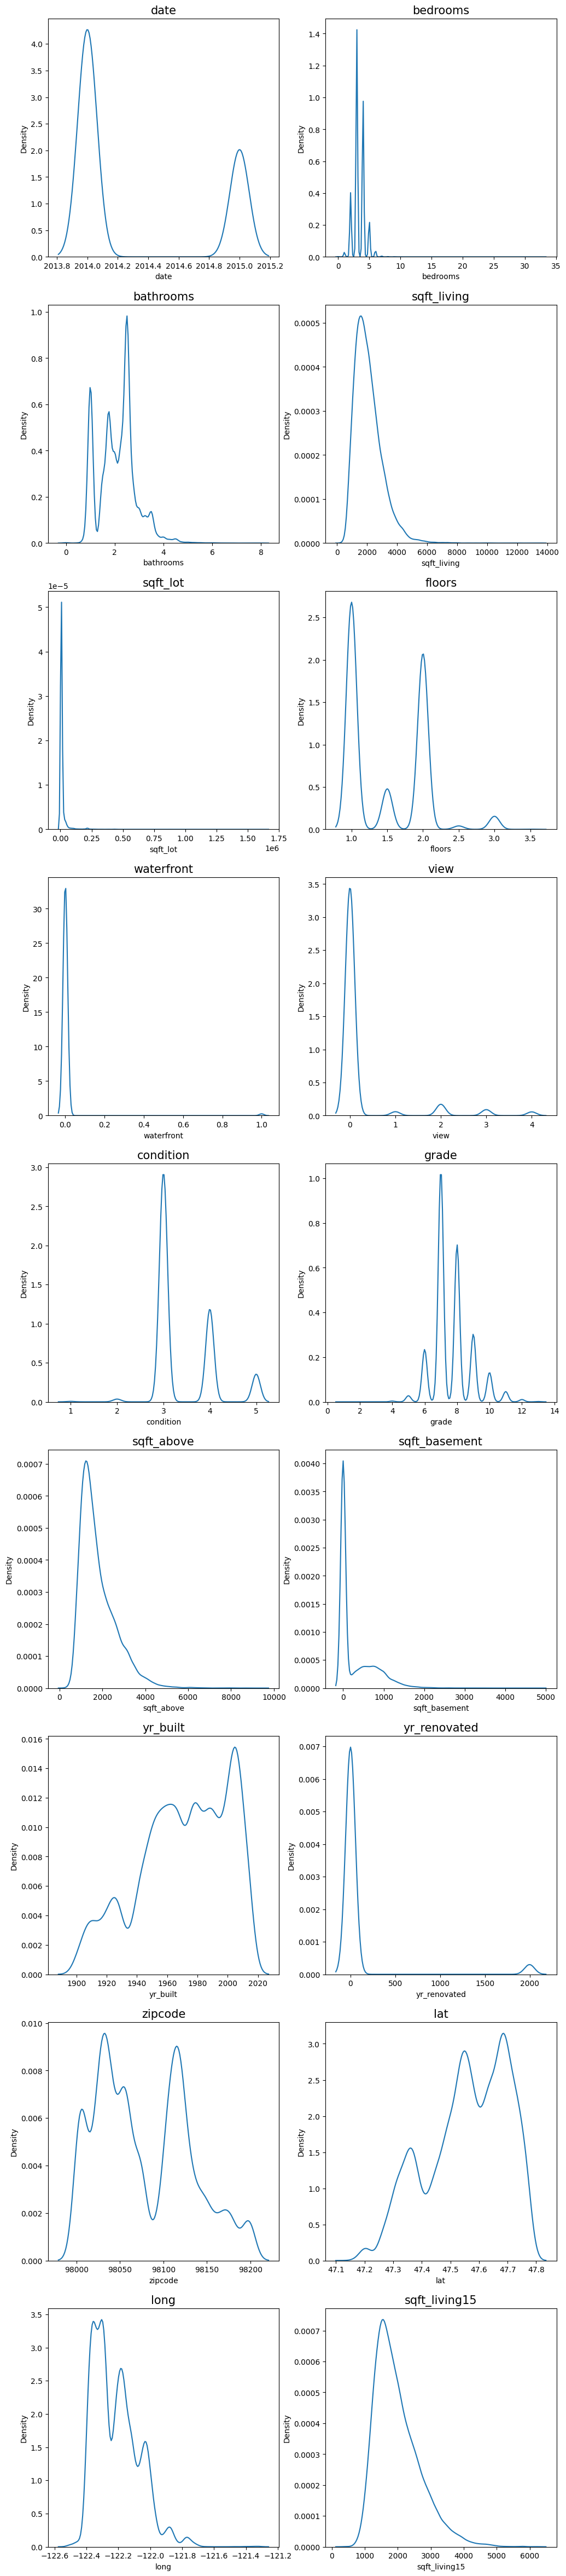

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(9, 2, figsize=(12, 60)) # 컬럼의 수가 18개이므로 9행 2열

count = 0
columns = train.columns
for row in range(int(len(columns) / 2)):    # 컬럼 수 / 2 = 행 개수
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == len(columns) :  # count == 컬럼 수
            break

일부 컬럼들을 정규분포의 형태로 변환합니다

In [13]:
import numpy as np

skew_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

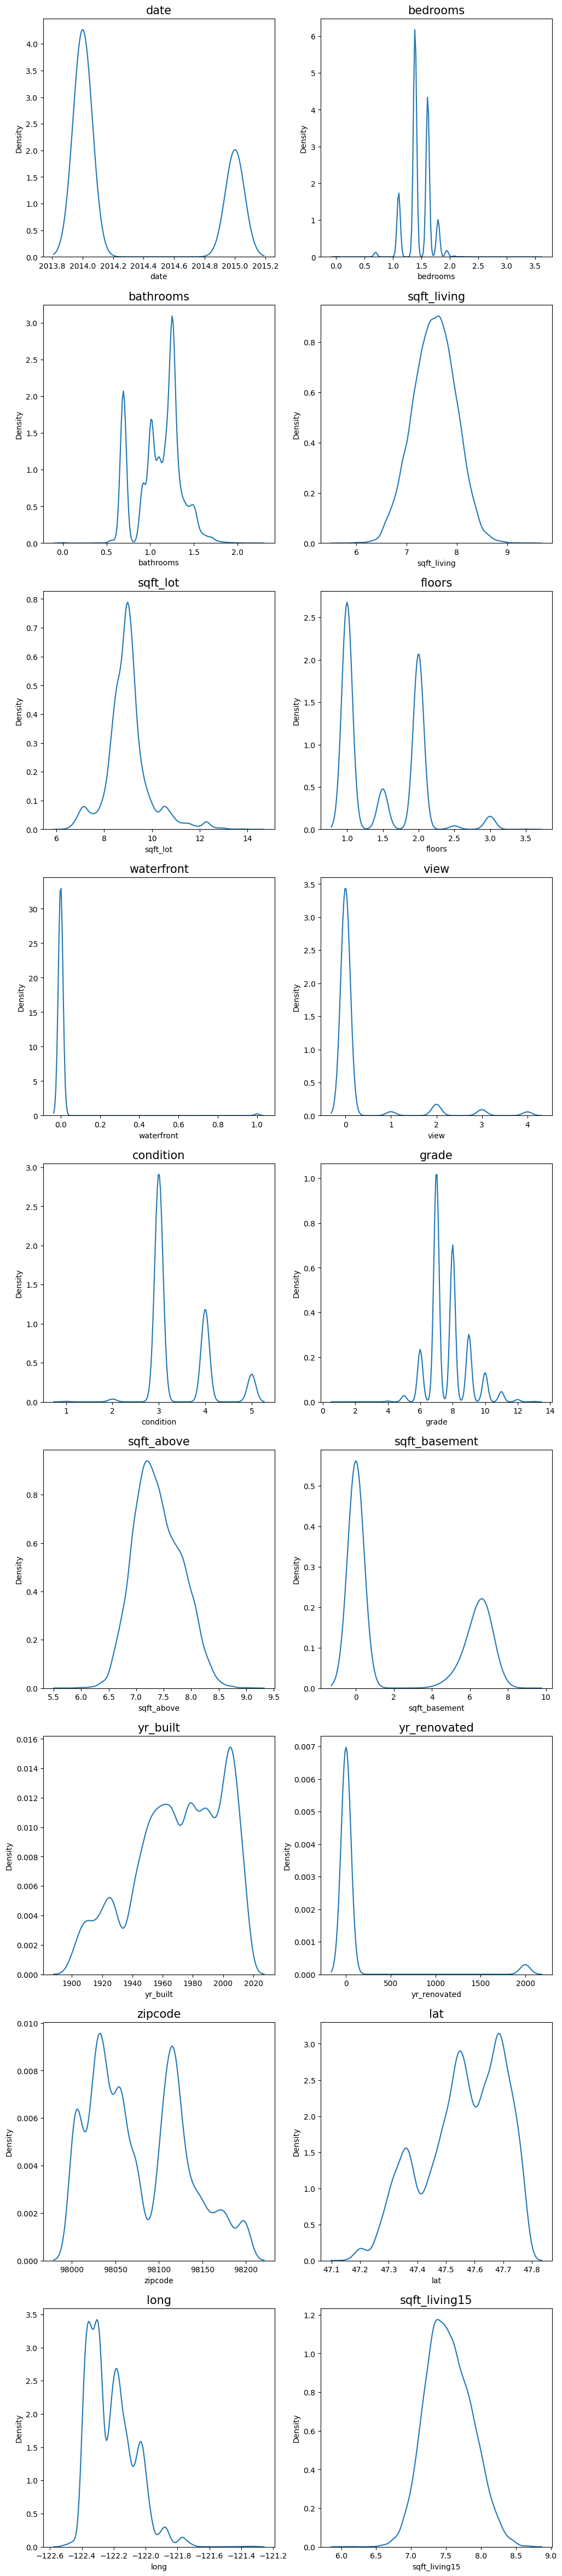

In [14]:
fig, ax = plt.subplots(9, 2, figsize=(12, 60))

count = 0
columns = train.columns
for row in range(int(len(columns) / 2)):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == len(columns) :
            break

y를 확인합니다.

<Axes: xlabel='price', ylabel='Density'>

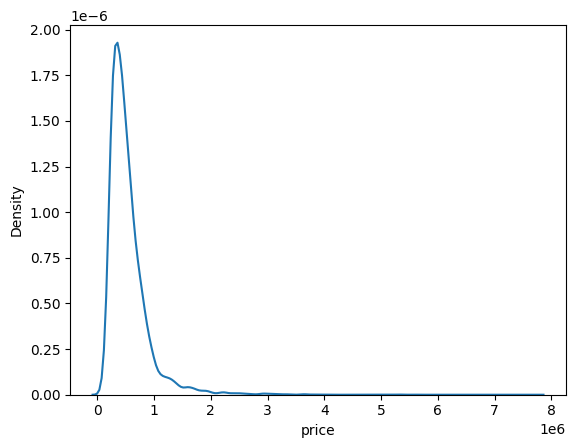

In [15]:
sns.kdeplot(y)

y를 정규분포의 형태로 변환합니다.

<Axes: xlabel='price', ylabel='Density'>

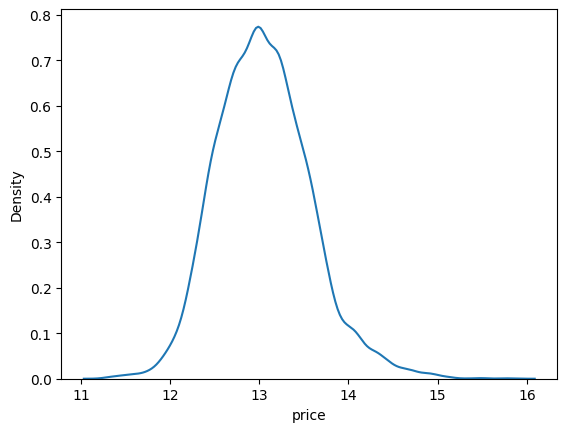

In [16]:
y = np.log1p(y)
sns.kdeplot(y)

다시 train, test 데이터를 분리합니다.

In [17]:
test = train.iloc[train_len:, :]
train = train.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


모델을 만들 차례입니다.  
먼저 rmse를 구하는 함수를 작성합니다.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

성능 비교를 위해 여러 모델들을 불러옵니다.

In [19]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [20]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

각 모델들을 학습시켜 RMSE를 구합니다.

이 때 feature_importances를 사용해 각 특성의 중요도를 표시합니다.  
(LGBM을 제외한 중요도의 범위는 0~1입니다.)

In [21]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_pred, y_test)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
        print(model_name)   # 모델 이름
        for i in range(len(X_train.columns)):   # 반복 횟수: train 데이터의 컬럼 수
            print(f'{X_train.columns[i]}: {model.feature_importances_[i]}') # 컬럼명: 중요도
        print('--------------------------------------------------------------')
    return score_df

get_scores(models, train, y)

GradientBoostingRegressor
date: 0.0018883834361254688
bedrooms: 0.00020039183036270824
bathrooms: 0.0025858744332829206
sqft_living: 0.2790510116520042
sqft_lot: 0.009736975963124783
floors: 4.3689345213682035e-06
waterfront: 0.005120754218059007
view: 0.02265096246858573
condition: 0.005232457236733536
grade: 0.28414521952682553
sqft_above: 0.007521173819494642
sqft_basement: 0.00045886080283089053
yr_built: 0.018390889212875954
yr_renovated: 0.0013195588659453002
zipcode: 0.007981848916390285
lat: 0.30592985495051256
long: 0.02248350543660056
sqft_living15: 0.02254279294669907
sqft_lot15: 0.0027551153490256637
--------------------------------------------------------------
XGBRegressor
date: 0.0049972799606621265
bedrooms: 0.0029706070199608803
bathrooms: 0.0031974941957741976
sqft_living: 0.11436587572097778
sqft_lot: 0.006523273419588804
floors: 0.003688826458528638
waterfront: 0.11415253579616547
view: 0.07570699602365494
condition: 0.014548110775649548
grade: 0.47927403450012207
s

,RMSE
GradientBoostingRegressor,129350.888015
RandomForestRegressor,125064.970222
LGBMRegressor,113267.248722
XGBRegressor,113031.751026


생각보다 RMSE가 크게 나옵니다.

각 모델에서 공통적으로 중요도가 많이 떨어지는 컬럼들이 보입니다.  

date만 삭제 해봅니다.

In [24]:
train_new = train.drop(columns=['date'])
test_new = test.drop(columns=['date'])

train_new.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,1.386294,0.693147,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,98178,47.5112,-122.257,7.201171,8.639588
1,1.098612,0.693147,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,98028,47.7379,-122.233,7.908755,8.995041
2,1.386294,1.098612,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,98074,47.6168,-122.045,7.496097,8.923191
3,1.386294,1.178655,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,98003,47.3097,-122.327,7.713785,8.827615
4,1.386294,0.916291,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,98198,47.4095,-122.315,7.409136,9.181118


In [25]:
get_scores(models, train_new, y)

GradientBoostingRegressor
bedrooms: 0.00017985386829213123
bathrooms: 0.002704367173114581
sqft_living: 0.2795321814700326
sqft_lot: 0.009651527001255801
floors: 0.0
waterfront: 0.005167090601419207
view: 0.022868224994569305
condition: 0.0045085092150898886
grade: 0.284502640017287
sqft_above: 0.007375663938102651
sqft_basement: 0.0004169101512015442
yr_built: 0.01890205353945776
zipcode: 0.008183559428154566
lat: 0.3073427354815203
long: 0.023845161123407694
sqft_living15: 0.02219980024672092
sqft_lot15: 0.002619721750373989
--------------------------------------------------------------
XGBRegressor
bedrooms: 0.0029333573766052723
bathrooms: 0.0038714592810720205
sqft_living: 0.12122879922389984
sqft_lot: 0.007709032855927944
floors: 0.003323611570522189
waterfront: 0.09318012744188309
view: 0.08107897639274597
condition: 0.01596386544406414
grade: 0.4864552617073059
sqft_above: 0.007831963710486889
sqft_basement: 0.0048813954927027225
yr_built: 0.01157587394118309
zipcode: 0.0117418

,RMSE
GradientBoostingRegressor,128726.410305
RandomForestRegressor,125380.331187
XGBRegressor,118086.474461
LGBMRegressor,114426.722345


RMSE가 살짝 더 커졌습니다..

데이터 전처리는 이쯤 하도록 하고 하이퍼 파라미터 튜닝을 하겠습니다.  
먼저 GridSearch를 하는 함수를 작성합니다.

In [26]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    
    return results.sort_values(by='RMSLE')

LGBMRegressor가 가장 높은 RMSE가 낮았기에 모델로 LGBMRegressor를 선택합니다.

param_grid에 하이퍼 파라미터를 직접 입력해 하이퍼 파라미터 튜닝을 시행합니다.

In [27]:
param_grid = {
    'n_estimators': [150, 175, 200],
    'max_depth': [15, 20],
    'learning_rate': [0.1],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_new, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
5,0.1,20,200,-0.027531,0.165926
2,0.1,15,200,-0.027564,0.166023
1,0.1,15,175,-0.027586,0.166092
4,0.1,20,175,-0.027600,0.166131
3,0.1,20,150,-0.027696,0.166420
0,0.1,15,150,-0.027732,0.166529


In [28]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)

    prediction = model.predict(test)
    prediction = np.expm1(prediction)

    submission_path = 'sample_submission.csv'
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction

    submission_csv_path = 'submission_{}_RMSLE_{}.csv'.format(model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)

In [29]:
model = LGBMRegressor(learning_rate=0.1, max_depth=20, n_estimators=200, random_state=random_state)
save_submission(model, train_new, y, test_new, 'lgbm', rmsle='0.164634')